In [41]:
import yaml
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from INEGIpy import Indicadores
from sie_banxico import SIEBanxico

In [42]:
def cargar_config(ruta_archivo='tokens.yaml'):
    """
    Carga los tokens de APIs desde un archivo YAML de configuración.
    
    Args:
        ruta_archivo (str): Ruta al archivo YAML (por defecto 'tokens.yaml')
        
    Returns:
        dict: Diccionario con la configuración cargada
    """
    try:
        with open(ruta_archivo, 'r') as archivo:
            config = yaml.safe_load(archivo)
        print("✅ Configuración cargada exitosamente")
        return config
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {ruta_archivo}")
        print(f"   Crea este archivo con la estructura adecuada para los tokens")
        return None
    except yaml.YAMLError as e:
        print(f"❌ Error al parsear el archivo YAML: {e}")
        return None

In [43]:
def obtener_inflacion_inegi(token_inegi, fecha_inicio=None, fecha_fin=None):
    """
    Obtiene datos de inflación (INPC) del INEGI utilizando directamente la clase Indicadores.
    
    Esta función consulta específicamente el indicador 910399 que corresponde al:
    "Índice Nacional de Precios al Consumidor (INPC) - Índice general - Variación porcentual mensual"
    Ruta temática: Indicadores económicos de coyuntura > Índices de precios > INPC. 
    Base segunda quincena Julio 2018. Actualización de Canasta y Ponderadores 2024 > 
    Mensual > Inflación mensual > Índice general
    
    Args:
        token_inegi (str): Token de acceso para la API de INEGI
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        
    Returns:
        DataFrame: DataFrame con los datos de inflación con columnas 'fecha' e 'inflacion_mensual'
    """
    try:
        # Si no se especifican fechas, establecemos valores predeterminados
        if not fecha_inicio:
            fecha_inicio = '2019-12-31'  # Por defecto, 5 años atrás
        if not fecha_fin:
            fecha_fin = '2024-12-31'  # Por defecto, hasta final de 2024
        
        # Inicializamos directamente la clase Indicadores con el token
        inegi_indicadores = Indicadores(token=token_inegi)
        
        # Usamos el método obtener_df de la clase Indicadores
        # Indicador 910399: INPC mensual, variación porcentual, índice general
        df_inflacion = inegi_indicadores.obtener_df(
            indicadores='910399',
            nombres='inflacion_mensual',
            inicio=fecha_inicio,
            fin=fecha_fin,
            banco='BIE'  # Especificamos explícitamente el banco
        )
        
        # Preparamos el dataframe para análisis posterior
        df_inflacion = df_inflacion.reset_index()
        df_inflacion.rename(columns={'fechas': 'fecha'}, inplace=True)
        
        # Ordenamos por fecha para asegurar coherencia en visualizaciones y análisis
        df_inflacion = df_inflacion.sort_values('fecha')
        
        print(f"✅ Datos de inflación obtenidos: {len(df_inflacion)} registros")
        print(f"   Período: {df_inflacion['fecha'].min().strftime('%Y-%m-%d')} a {df_inflacion['fecha'].max().strftime('%Y-%m-%d')}")
        
        return df_inflacion
    
    except Exception as e:
        print(f"❌ Error al obtener datos de inflación del INEGI: {e}")
        print("   Verifica el token y la conexión a internet.")
        return None

In [44]:
def obtener_tasa_interes_banxico(token, fecha_inicio=None, fecha_fin=None, frecuencia='mensual'):
    """
    Obtiene datos de la tasa de interés de CETES a 28 días directamente desde Banxico,
    y convierte los datos a frecuencia mensual si es necesario.
    
    Esta función consulta específicamente la serie SF43783 que corresponde a:
    "Tasas de interés de valores gubernamentales - Tasa de rendimiento 
    promedio mensual de CETES 28 días"
    
    Args:
        token (str): Token de la API de Banxico
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        frecuencia (str, optional): Frecuencia de datos ('diaria' o 'mensual')
        
    Returns:
        DataFrame: DataFrame con los datos de tasas de interés con columnas 'fecha' y 'tasa_cetes28'
    """
    # Si no se especifican fechas, tomamos los últimos tres años para tener datos suficientes
    if not fecha_inicio:
        fecha_inicio = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')
    if not fecha_fin:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')
    
    try:
        # Importamos la biblioteca SIEBanxico
        from sie_banxico import SIEBanxico
        
        # Inicializamos el cliente con el token y la serie SF43783 (Tasa de CETES 28 días)
        banxico = SIEBanxico(token=token, id_series=['SF43783'], language='es')
        
        # Obtenemos la serie en el rango de fechas especificado
        respuesta = banxico.get_timeseries_range(init_date=fecha_inicio, end_date=fecha_fin)
        
        # Extraemos los datos de la respuesta JSON
        datos = respuesta['bmx']['series'][0]['datos']
        
        # Convertimos a DataFrame
        df = pd.DataFrame(datos)
        
        # Procesamos el DataFrame
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
        df['dato'] = df['dato'].str.replace(',', '').astype(float)
        
        # Renombramos la columna de valores
        df = df.rename(columns={'dato': 'tasa_cetes28'})
        
        # La serie SF43783 normalmente ya viene en frecuencia mensual, pero verificamos
        # si hay múltiples registros por mes y aplicamos la conversión si es necesario
        
        # Creamos una columna de año-mes para verificar la frecuencia
        df['año_mes'] = df['fecha'].dt.to_period('M')
        
        # Contamos cuántos registros hay por mes
        registros_por_mes = df.groupby('año_mes').size()
        
        # Si hay meses con múltiples registros y se solicita frecuencia mensual, hacemos la conversión
        if registros_por_mes.max() > 1 and frecuencia.lower() == 'mensual':
            # Agrupamos por año-mes y calculamos el promedio
            df_mensual = df.groupby('año_mes').agg({
                'tasa_cetes28': 'mean'  # Promedio mensual de la tasa
            }).reset_index()
            
            # Convertimos la columna año_mes a fecha (primer día del mes)
            df_mensual['fecha'] = df_mensual['año_mes'].dt.to_timestamp()
            
            # Redondeamos los valores para mejor legibilidad
            df_mensual['tasa_cetes28'] = df_mensual['tasa_cetes28'].round(2)
            
            # Eliminamos la columna auxiliar y ordenamos por fecha
            df_mensual = df_mensual.drop(columns=['año_mes']).sort_values('fecha')
            
            print(f"✅ Datos de tasa de interés CETES 28 días (SF43783) convertidos a frecuencia mensual: {len(df_mensual)} registros")
            print(f"   Período: {df_mensual['fecha'].min().strftime('%Y-%m-%d')} a {df_mensual['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df_mensual
        else:
            # Si ya están en frecuencia mensual o se solicita la frecuencia original
            df = df.drop(columns=['año_mes']).sort_values('fecha')
            
            frecuencia_actual = "mensual" if registros_por_mes.max() <= 1 else "mayor a mensual"
            print(f"✅ Datos de tasa de interés CETES 28 días (SF43783) con frecuencia {frecuencia_actual}: {len(df)} registros")
            print(f"   Período: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df
    
    except ImportError:
        print("❌ Error: No se encontró la biblioteca sie_banxico.")
        print("   Por favor, instálala con: pip install sie_banxico")
        return None
    except Exception as e:
        print(f"❌ Error al obtener datos de Banxico: {e}")
        print("   Verifica que el token sea válido y que tengas conexión a internet.")
        return None

In [45]:
def obtener_tipo_cambio_banxico(token, fecha_inicio=None, fecha_fin=None, frecuencia='mensual'):
    """
    Obtiene el tipo de cambio FIX (SF43718) peso-dólar usando la biblioteca SIEBanxico,
    y convierte los datos a frecuencia mensual.
    
    Esta función consulta específicamente la serie SF43718 que corresponde al:
    "Tipo de cambio, pesos por dólar E.U.A.(Diaria) Tipo de cambio para solventar 
    obligaciones denominadas en dólares Fecha de determinación (FIX)"
    
    Args:
        token (str): Token de la API de Banxico
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        frecuencia (str, optional): Frecuencia de datos ('diaria' o 'mensual')
        
    Returns:
        DataFrame: DataFrame con los datos de tipo de cambio con columnas 'fecha' y 'tipo_cambio'
    """
    # Si no se especifican fechas, tomamos los últimos tres años para tener datos suficientes
    # al convertir a frecuencia mensual
    if not fecha_inicio:
        fecha_inicio = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')
    if not fecha_fin:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')
    
    try:
        # Importamos la biblioteca SIEBanxico
        from sie_banxico import SIEBanxico
        
        # Inicializamos el cliente con el token y la serie SF43718 (Tipo de cambio FIX)
        banxico = SIEBanxico(token=token, id_series=['SF43718'], language='es')
        
        # Obtenemos la serie en el rango de fechas especificado
        respuesta = banxico.get_timeseries_range(init_date=fecha_inicio, end_date=fecha_fin)
        
        # Extraemos los datos de la respuesta JSON
        datos = respuesta['bmx']['series'][0]['datos']
        
        # Convertimos a DataFrame
        df = pd.DataFrame(datos)
        
        # Procesamos el DataFrame
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
        df['dato'] = df['dato'].str.replace(',', '').astype(float)
        
        # Renombramos la columna de valores
        df = df.rename(columns={'dato': 'tipo_cambio'})
        
        # Si se solicita frecuencia mensual, convertimos los datos diarios a promedios mensuales
        if frecuencia.lower() == 'mensual':
            # Creamos una columna de año-mes para agrupar
            df['año_mes'] = df['fecha'].dt.to_period('M')
            
            # Agrupamos por año-mes y calculamos el promedio
            df_mensual = df.groupby('año_mes').agg({
                'tipo_cambio': 'mean'  # Promedio mensual del tipo de cambio
            }).reset_index()
            
            # Convertimos la columna año_mes a fecha (primer día del mes)
            df_mensual['fecha'] = df_mensual['año_mes'].dt.to_timestamp()
            
            # Redondeamos los valores para mejor legibilidad
            df_mensual['tipo_cambio'] = df_mensual['tipo_cambio'].round(4)
            
            # Eliminamos la columna auxiliar y ordenamos por fecha
            df_mensual = df_mensual.drop(columns=['año_mes']).sort_values('fecha')
            
            print(f"✅ Datos de tipo de cambio FIX (SF43718) convertidos a frecuencia mensual: {len(df_mensual)} registros")
            print(f"   Período: {df_mensual['fecha'].min().strftime('%Y-%m-%d')} a {df_mensual['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df_mensual
        
        # Si se mantiene la frecuencia diaria, retornamos los datos originales
        print(f"✅ Datos de tipo de cambio FIX (SF43718) con frecuencia diaria: {len(df)} registros")
        print(f"   Período: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
        
        return df
    
    except ImportError:
        print("❌ Error: No se encontró la biblioteca sie_banxico.")
        print("   Por favor, instálala con: pip install sie_banxico")
        return None
    except Exception as e:
        print(f"❌ Error al obtener datos de Banxico: {e}")
        print("   Verifica que el token sea válido y que tengas conexión a internet.")
        return None

In [46]:
def explorar_indicadores_inegi(token_inegi, busqueda=None, banco='BIE'):
    """
    Explora el catálogo de indicadores disponibles en INEGI utilizando directamente la clase Indicadores.
    Opcionalmente filtra por términos de búsqueda.
    
    Args:
        token_inegi (str): Token de acceso para la API de INEGI
        busqueda (str, optional): Término para filtrar indicadores
        banco (str): Banco de indicadores a consultar ('BIE' o 'BISE')
        
    Returns:
        DataFrame: DataFrame con los indicadores encontrados
    """
    try:
        # Inicializamos directamente la clase Indicadores con el token
        inegi_indicadores = Indicadores(token=token_inegi)
        
        # Obtenemos el catálogo completo de indicadores
        indicadores = inegi_indicadores.catalogo_indicadores(banco=banco)
        
        # Si se proporciona un término de búsqueda, filtramos
        if busqueda:
            indicadores_filtrados = indicadores[
                indicadores['descripcion'].str.contains(busqueda, case=False, regex=True)
            ]
            print(f"✅ Se encontraron {len(indicadores_filtrados)} indicadores relacionados con '{busqueda}'")
            return indicadores_filtrados
        
        print(f"✅ Se encontraron {len(indicadores)} indicadores en el banco {banco}")
        return indicadores
        
    except Exception as e:
        print(f"❌ Error al consultar el catálogo de indicadores: {e}")
        return None

In [47]:
# Cargamos la configuración 
config = cargar_config()
if not (config and 'banxico' in config and 'inegi' in config):
    print("❌ Error: Configuración incompleta. Verifica el archivo config.yaml")


# Obtenemos tokens 
token_banxico = config['banxico']['token']
token_inegi = config['inegi']['token']
inegi_indicadores = Indicadores(token=token_inegi)

✅ Configuración cargada exitosamente


In [48]:
# Definimos el rango de fechas (últimos diez años)
fecha_fin = '2024-12-01'  # Fecha fija: final del año 2024
fecha_inicio = '2014-12-01'  # Fecha fija: 5 años antes del fin (para tener un buen rango de datos)
    

print(f"\n📅 Periodo de análisis: {fecha_inicio} a {fecha_fin}")


📅 Periodo de análisis: 2014-12-01 a 2024-12-01


In [49]:
print("\n📊 Descargando datos económicos...")
df_tipo_cambio = obtener_tipo_cambio_banxico(token_banxico, fecha_inicio, fecha_fin)
df_inflacion = obtener_inflacion_inegi(token_inegi, fecha_inicio, fecha_fin)
df_tasas = obtener_tasa_interes_banxico(token_banxico, fecha_inicio, fecha_fin)


📊 Descargando datos económicos...
✅ Datos de tipo de cambio FIX (SF43718) convertidos a frecuencia mensual: 120 registros
   Período: 2014-12-01 a 2024-11-01


/opt/homebrew/Caskroom/miniconda/base/envs/analisis-economico/lib/python3.11/site-packages/INEGIpy/_indicadores.py:112: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.set_index(pd.to_datetime(df.fechas),inplace=True, drop=True)


✅ Datos de inflación obtenidos: 121 registros
   Período: 2014-12-01 a 2024-12-01
✅ Datos de tasa de interés CETES 28 días (SF43783) convertidos a frecuencia mensual: 120 registros
   Período: 2014-12-01 a 2024-11-01


In [50]:
df_tipo_cambio.head()

,tipo_cambio,fecha
0,14.5129,2014-12-01
1,14.6926,2015-01-01
2,14.9213,2015-02-01
3,15.2283,2015-03-01
4,15.2262,2015-04-01


In [51]:
df_inflacion.head()

,fecha,inflacion_mensual
0,2014-12-01,0.49
1,2015-01-01,-0.09
2,2015-02-01,0.19
3,2015-03-01,0.41
4,2015-04-01,-0.26


In [52]:
df_tasas.head()

,tasa_cetes28,fecha
0,3.3,2014-12-01
1,3.3,2015-01-01
2,3.3,2015-02-01
3,3.3,2015-03-01
4,3.3,2015-04-01


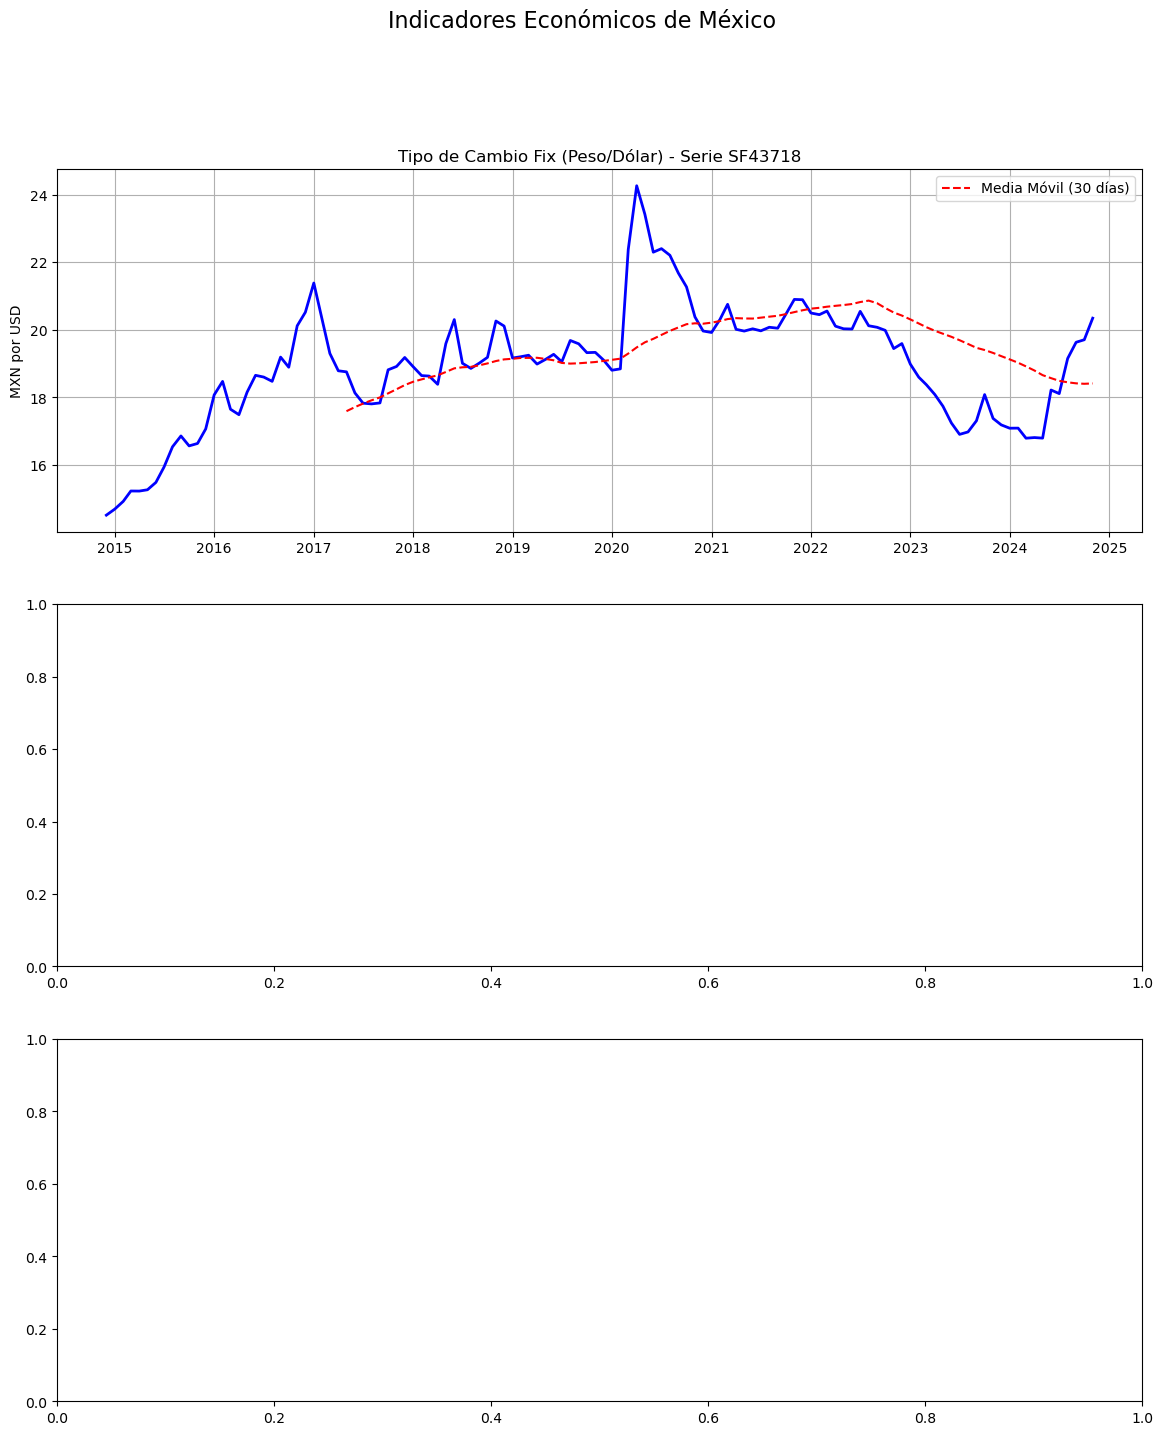

In [55]:
df_tc = df_tipo_cambio

# Configuramos el espacio para las gráficas
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=False)
fig.suptitle('Indicadores Económicos de México', fontsize=16)

# 1. Gráfica de Tipo de Cambio
axes[0].plot(df_tc['fecha'], df_tc['tipo_cambio'], 'b-', linewidth=2)
axes[0].set_title('Tipo de Cambio Fix (Peso/Dólar) - Serie SF43718')
axes[0].set_ylabel('MXN por USD')
axes[0].grid(True)

# Añadimos una línea de tendencia (media móvil)
if len(df_tc) > 30:
    df_tc['ma30'] = df_tc['tipo_cambio'].rolling(window=30).mean()
    axes[0].plot(df_tc['fecha'], df_tc['ma30'], 'r--', linewidth=1.5, 
                label='Media Móvil (30 días)')
    axes[0].legend()

# 2. Gráfica de Inflación
# Si tenemos tanto inflación mensual como anual, mostramos ambas
if 'inflacion_anual' in df_inflacion.columns:
    ax1 = axes[1]
    ax2 = ax1.twinx()  # Creamos un segundo eje y para la inflación mensual
    
    # Inflación anual (acumulado 12 meses)
    ax1.plot(df_inflacion['fecha'], df_inflacion['inflacion_anual'], 'g-', linewidth=2, label='Anual (12 meses)')
    ax1.set_ylabel('Inflación Anual (%)', color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Inflación mensual
    ax2.plot(df_inflacion['fecha'], df_inflacion['inflacion_mensual'], 'm-', linewidth=1.5, label='Mensual')
    ax2.set_ylabel('Inflación Mensual (%)', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    # Combinamos las leyendas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    axes[1].set_title('Inflación (INPC) - Indicador 910399 - Índice general')
else:
    # Solo tenemos inflación mensual
    axes[1].plot(df_inflacion['fecha'], df_inflacion['inflacion_mensual'], 'm-', linewidth=2)
    axes[1].set_title('Inflación Mensual (INPC) - Indicador 910399 - Índice general')
    axes[1].set_ylabel('Variación Porcentual (%)')

axes[1].grid(True)

# 3. Gráfica de Tasas de Interés
axes[2].plot(df_tasas['fecha'], df_tasas['tasa_cetes28'], 'purple', linewidth=2)
axes[2].set_title('Tasa de CETES a 28 días - Serie SF43783 (Banxico)')
axes[2].set_ylabel('Porcentaje (%)')
axes[2].grid(True)

# Mejoramos la presentación
plt.tight_layout()
plt.subplots_adjust(top=0.92)
    